# Hydro reservoir content in Norway

We want to forecast weekly hydro content (HRC) in Norway. The formula is provided as follows: <br>
**t**: week number. <br>
**Inflow**: River flows (Atnasjo, Ovrevatin, Gaulfoss, Austena, Bulken) in Norway. <br>
#### Inflow(t) + Precipitation(t) + HRC(t-1) - HydroProduction(t) = HRC(t) 

## Import packages to run Python scripts

In [1]:
import cdb_pycomm_lib as cdb
#cdb.CDBCONFIG.config
import datetime
import cdb_pycomm_lib.cdbutils as utils
import cdb_pycomm_lib.cdbreader as pycomm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.arima_model import ARMA
from pmdarima import auto_arima
import warnings
import re
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
#from datetime import datetime
import pickle
import csv
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
from subprocess import check_call
from io import StringIO
## https://stackoverflow.com/questions/33433274/anaconda-graphviz-cant-import-after-installation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

#### Calibration files

We need synthetic Hydro production data, due to the lack of actual data. <br>
#### HydroProduction(t) = Demand(t) - Thermal(t) - Wind(t) - NetImport(t)
Thermal has smal share of whole power production, so I will use ARIMA model to forecast it. It means that we need a folder path to save all calibration files.

In [2]:
arima_calibration = r'C:\Users\U6087214\OneDrive - London Stock Exchange Group\Desktop\SDDP'

## Time Setting
I will use the forecast values that are available in DB regarding wind, inflow, precepitation, NetImport, and temperature. To keep the dynamics and use the updated data, I need to use 'today' as forecast date:  

In [3]:
f1 = utils.today()

The length of historical data is important to have a reliable forecast. The barrier is the increasing number of NAN values by using longer time series data. In this example, we use data from 2018-05. In addition, we need data starts from Monday because our final estimation is weekly and the first day is Monday.

In [4]:
# https://www.geeksforgeeks.org/how-to-find-the-first-monday-of-a-given-month-using-numpy/
# input year and month
yearMonth = '2018-05'
# getting date of first monday
date_first_monday = np.busday_offset(yearMonth, 0, roll='forward', weekmask='Mon')
date_first_monday = date_first_monday.astype(datetime.datetime)

We need a historical time windows to have timeseries data with the same size. 

In [5]:
time_series_range = pd.date_range(date_first_monday,f1 , freq='H')

time_series_df = pd.DataFrame()
time_series_df['VD'] = time_series_range

### Reading NetImport forecast (NO1, NO2, NO3, NO4, NO5) curves 

In [6]:
# NO1

no1_NetImport_forecast = pycomm.get_curves(106317315, f1)

# NO2

no2_NetImport_forecast = pycomm.get_curves(106317266, f1)

# NO3

no3_NetImport_forecast = pycomm.get_curves(106317425, f1)

# NO4

no4_NetImport_forecast = pycomm.get_curves(106317318, f1)

# NO5

no5_NetImport_forecast = pycomm.get_curves(106317358, f1)

### Aggregating NetImport Forecast 

<AxesSubplot:xlabel='Date'>

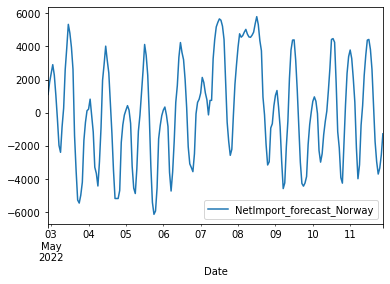

In [7]:
no_whole_NetImport_forecast = pd.DataFrame()
no_whole_NetImport_forecast['Date'] = no1_NetImport_forecast['VD']
no_whole_NetImport_forecast['NetImport_forecast_Norway'] = no1_NetImport_forecast['V'] + no2_NetImport_forecast['V'] + no3_NetImport_forecast['V'] + no4_NetImport_forecast['V'] + no5_NetImport_forecast['V']
no_whole_NetImport_forecast = no_whole_NetImport_forecast.set_index('Date')
no_whole_NetImport_forecast.plot(legend = True)

### Forecast horizon
I use the last timestamp regarding NetImport forecast as forecast horizon for all variables. The main reason to specify forecast horizon is that all independent variables, e.g. inflow, netImport and thermal forecast, have not the same forecast horizon.   

In [8]:
time_end_forecast = no_whole_NetImport_forecast.index[-1]

### Reading Wind forecast curve

<AxesSubplot:xlabel='Date'>

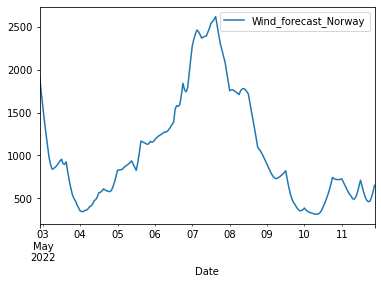

In [9]:
## NO1
# Here curve is dynamic and we don't specify the other arguments except f1:
no1_wind_forecast = pycomm.get_curves(107082624, f1)

## NO2
no2_wind_forecast = pycomm.get_curves(107082776, f1)
## NO3
no3_wind_forecast = pycomm.get_curves(107082729, f1)
## NO4
no4_wind_forecast = pycomm.get_curves(107082686, f1)
## NO5
no5_wind_forecast = pycomm.get_curves(107082726, f1)

no_whole_wind_forecast = pd.DataFrame()
no_whole_wind_forecast['Date'] = no1_wind_forecast['VD']
no_whole_wind_forecast['Wind_forecast_Norway'] = no1_wind_forecast['V'] + no2_wind_forecast['V'] + no3_wind_forecast['V'] + no4_wind_forecast['V'] + no5_wind_forecast['V']
no_whole_wind_forecast = no_whole_wind_forecast.set_index('Date')
no_whole_wind_forecast = no_whole_wind_forecast.loc[:time_end_forecast]
no_whole_wind_forecast.plot(legend = True)

### Reading River flow and Temperature forecast curve

<AxesSubplot:xlabel='Date'>

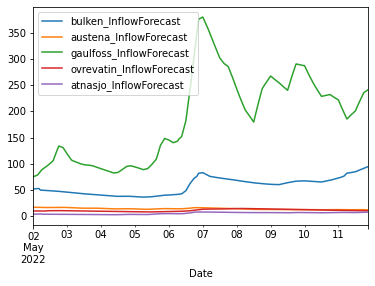

In [10]:
# Bulken

bulken_TempForecast = pycomm.get_curves(116981362, f1,f1)
bulken_InflowForecast = pycomm.get_curves(117694936, f1,f1)
tmp_forecast_period = len(bulken_InflowForecast)
bulken_TempForecast = bulken_TempForecast.iloc[:tmp_forecast_period,:]

# Austena

austena_TempForecast = pycomm.get_curves(116981302,  f1,f1)
austena_InflowForecast = pycomm.get_curves(117694938, f1,f1)
austena_TempForecast = austena_TempForecast.iloc[:tmp_forecast_period,:]
austena_InflowForecast = austena_InflowForecast.iloc[:tmp_forecast_period,:]
# Gaulfoss

gaulfoss_TempForecast = pycomm.get_curves(116981360,  f1,f1)
gaulfoss_InflowForecast = pycomm.get_curves(117694942,  f1,f1)
gaulfoss_TempForecast = gaulfoss_TempForecast.iloc[:tmp_forecast_period,:]
gaulfoss_InflowForecast = gaulfoss_InflowForecast.iloc[:tmp_forecast_period,:]

# Ovrevatin

ovrevatin_TempForecast = pycomm.get_curves(116981493, f1,f1)
ovrevatin_InflowForecast = pycomm.get_curves(117694939, f1,f1)
ovrevatin_TempForecast = ovrevatin_TempForecast.iloc[:tmp_forecast_period,:]
ovrevatin_InflowForecast = ovrevatin_InflowForecast.iloc[:tmp_forecast_period,:]

# Atnasjo

atnasjo_TempForecast = pycomm.get_curves(116981498, f1,f1)
atnasjo_InflowForecast = pycomm.get_curves(117694937, f1,f1)
atnasjo_TempForecast = atnasjo_TempForecast.iloc[:tmp_forecast_period,:]
atnasjo_InflowForecast = atnasjo_InflowForecast.iloc[:tmp_forecast_period,:]

# Whole Norway

flow_whole_Norway_forecast = pd.DataFrame()
flow_whole_Norway_forecast['Date'] = bulken_TempForecast['VD']
flow_whole_Norway_forecast['bulken_TempForecast'] = bulken_TempForecast['V'] 
flow_whole_Norway_forecast['bulken_InflowForecast'] = bulken_InflowForecast['V']
flow_whole_Norway_forecast['austena_TempForecast'] = austena_TempForecast['V']
flow_whole_Norway_forecast['austena_InflowForecast'] = austena_InflowForecast['V']
flow_whole_Norway_forecast['gaulfoss_TempForecast'] = gaulfoss_TempForecast['V']
flow_whole_Norway_forecast['gaulfoss_InflowForecast'] = gaulfoss_InflowForecast['V']
flow_whole_Norway_forecast['ovrevatin_TempForecast'] = ovrevatin_TempForecast['V']
flow_whole_Norway_forecast['ovrevatin_InflowForecast'] = ovrevatin_InflowForecast['V']
flow_whole_Norway_forecast['atnasjo_TempForecast'] = atnasjo_TempForecast['V']
flow_whole_Norway_forecast['atnasjo_InflowForecast'] = atnasjo_InflowForecast['V']
flow_whole_Norway_forecast = flow_whole_Norway_forecast.set_index('Date')
# https://stackoverflow.com/questions/45390756/pandas-cannot-do-positional-indexing-on-datetimeindex-with-these-indexers-2016
flow_whole_Norway_forecast = flow_whole_Norway_forecast.loc[:time_end_forecast]
flow_whole_Norway_forecast[['bulken_InflowForecast','austena_InflowForecast',
                           'gaulfoss_InflowForecast','ovrevatin_InflowForecast',
                           'atnasjo_InflowForecast']].plot(legend = True)

### Reading Consumption forecast curve

<AxesSubplot:xlabel='Date'>

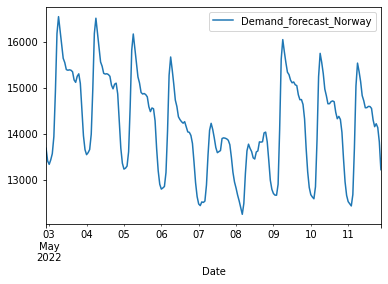

In [11]:
## NO1
no1_dem_forecast = pycomm.get_curves(107048386, f1)
## NO2
no2_dem_forecast = pycomm.get_curves(107048361, f1)
## NO3
no3_dem_forecast = pycomm.get_curves(107048375, f1)
## NO4
no4_dem_forecast = pycomm.get_curves(107048385, f1)

## NO5
no5_dem_forecast = pycomm.get_curves(107048377, f1)

no_whole_dem_forecast = pd.DataFrame()
no_whole_dem_forecast['Date'] = no1_dem_forecast['VD']
no_whole_dem_forecast['Demand_forecast_Norway'] = no1_dem_forecast['V'] + no2_dem_forecast['V'] + no3_dem_forecast['V'] + no4_dem_forecast['V'] + no5_dem_forecast['V'] 
no_whole_dem_forecast = no_whole_dem_forecast.set_index('Date')
no_whole_dem_forecast = no_whole_dem_forecast.loc[:time_end_forecast]
no_whole_dem_forecast.plot(legend = True)

### Function to fill back NaN

notAvailable function finds NaN and fill them back by using interpolation. 

In [12]:
# https://pandas.pydata.org/pandas-docs/version/0.17.0/merging.html

def notAvailable(curve,curve_name,inflow_Norway):
    inflow_Norway = pd.merge(inflow_Norway, curve, on=['VD'],  how='left')
    na_groups = inflow_Norway['V'].notna().cumsum()[inflow_Norway['V'].isna()]
    lengths_consecutive_na = na_groups.groupby(na_groups).agg(len)
    longest_na_gap = lengths_consecutive_na.max()
    if longest_na_gap >= 1:
        print('Consecutive NaN' +'_' + curve_name +': ' + f"{longest_na_gap}")
        if inflow_Norway['V'].first_valid_index() != 0:
            numb = inflow_Norway['V'].first_valid_index()
            inflow_Norway['V'].iloc[0] = inflow_Norway['V'].loc[inflow_Norway['V'].first_valid_index()]
            #inflow_Norway.iloc[0, inflow_Norway.columns.get_loc('V')] = numb
            #inflow_Norway.iloc[0, inflow_Norway.columns.get_loc('V')] = inflow_Norway['V'].loc[inflow_Norway['V'].first_valid_index()]
            #inflow_Norway['V'].loc[0]= inflow_Norway['V'].loc[inflow_Norway.first_valid_index()]
            curve = inflow_Norway.interpolate(method ='linear', limit_direction ='forward')
        else:
            curve = inflow_Norway.interpolate(method ='linear', limit_direction ='forward')
            
    elif lengths_consecutive_na.empty :
        print('Consecutive NaN' +'_' + curve_name +': Zero')
        curve = inflow_Norway.interpolate(method ='linear', limit_direction ='forward')
    else:
        print('Consecutive NaN' +'_' + curve_name +': Error')
        
    return curve

### ARIMA model for Thermal forecast

Thermal forecast is smal part of whole power production in Norway and getting corresponding forecast values is not an easy process, thus I use ARIMA model. I have made a function to build an ARIMA model based on different arguments. <br>
**days**: The number of days used to build model.<br>
**f1**: Today timestamp.<br>
**curve_id**: Curve id of actual data.<br>
**con_tech**: A string that shows name of technology.<br>
**auto_arima_true**: If we turn it to 'True', it means that the model should recalibrate itself. If it's 'False', it means that model should read calibration file from local system.<br>
**arima_calibration**: The folder path that is used to store calibration file.<br>
**test**: If 'True', it shows model performance by splitting the training data into two parts. If 'False', it uses the model to forecast data points regarding forcast horizon.<br>
**time_horizone_forecast**: Forecast horizon.

In [13]:
 def arima_forecast(days, f1,curve_id, con_tech, auto_arima_true, arima_calibration, test, time_horizone_forecast):
    f3 = f1-datetime.timedelta(days=days)

    time_range_extrapol = pd.date_range(f3,f1 , freq='H')

    inflow_extrapol = pd.DataFrame()
    inflow_extrapol['VD'] = time_range_extrapol
    hourlyRes_extrapol = inflow_extrapol['VD']
    tech_highRes = pycomm.get_curves(curve_id, f3 ,f1 , f3, f1) 
    data_date = pycomm.get_curves(curve_id, f3 ,f1 , f3, f1).iloc[:,-2].iloc[0].to_pydatetime() 
    tech_normal_reso = tech_highRes.loc[tech_highRes['VD'].isin(hourlyRes_extrapol)].reset_index(drop=True)
    tech_normal_reso = notAvailable(tech_normal_reso, con_tech, inflow_extrapol) #inflow_Norway shows date range
    tech_normal_reso = tech_normal_reso.set_index('VD')
    # We need longer timeseries data
    
    # https://www.geeksforgeeks.org/python-arima-model-for-time-series-forecasting/
    # https://goodboychan.github.io/python/datacamp/time_series_analysis/2020/06/16/02-Seasonal-ARIMA-Models.html
    
    # Ignore harmless warnings
    warnings.filterwarnings("ignore")
    
    # https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html
    # https://robjhyndman.com/hyndsight/seasonal-periods/
    # https://alkaline-ml.com/pmdarima/tips_and_tricks.html#period
    # Fit auto_arima function to AirPassengers dataset
    if auto_arima_true:
        stepwise_fit = auto_arima(tech_normal_reso['V'], start_p = 1, start_q = 1,
                                  max_p = 3, max_q = 3, m = 24,
                                  start_P = 0, seasonal = True,
                                  d = None, D = 1, trace = True,
                                  error_action ='ignore',   # we don't want to know if an order does not work
                                  suppress_warnings = True,  # we don't want convergence warnings
                                  stepwise = True)           # set to stepwise
        

        # To print the summary
        stepwise_fit.summary()
        results_summary = stepwise_fit.summary()
        results_as_html = results_summary.tables[0].as_html()
        
        #https://stackoverflow.com/questions/16729574/how-to-get-a-value-from-a-cell-of-a-dataframe
        read = pd.read_html(results_as_html, header=0, index_col=0)[0].iat[0,0]
        
        # https://stackoverflow.com/questions/4289331/how-to-extract-numbers-from-a-string-in-python
        model_order = [int(s) for s in re.findall(r'\b\d+\b', read)]
        
        # https://thispointer.com/python-how-to-insert-an-element-at-specific-index-in-list/#:~:text=Inserting%20an%20element%20in%20list,member%20function%20insert()%20i.e.&text=It%20accepts%20a%20position%20and,given%20position%20in%20the%20list.
        if len(model_order) == 6 :
            model_order.insert(-1, 0) 
        else:
            pass
        order_tech = tuple(model_order[0:3])
        seasonal_tech = tuple(model_order[3:])
        # https://www.geeksforgeeks.org/how-to-use-pickle-to-save-and-load-variables-in-python/#:~:text=In%20python%2C%20dumps()%20method,variables%20to%20a%20pickle%20file.
        # Open a file and use dump()
        with open(arima_calibration + '/'+con_tech+'_'+ 'arima_order.pkl', 'wb') as file:
            # A new file will be created
            pickle.dump(order_tech, file)
        
        with open(arima_calibration + '/'+con_tech+'_'+ 'arima_seasonal.pkl', 'wb') as file:
            # A new file will be created
            pickle.dump(seasonal_tech, file)
        
    else:
        with open(arima_calibration + '/'+ con_tech+'_'+'arima_order.pkl', 'rb') as file:
            # Call load method to deserialze
            order_tech = pickle.load(file)
            
        with open(arima_calibration + '/'+ con_tech+'_'+'arima_seasonal.pkl', 'rb') as file:
            # Call load method to deserialze
            seasonal_tech = pickle.load(file)
    
    if test:
        train_tech = tech_normal_reso.iloc[:len(tech_normal_reso)-30]
        test_tech = tech_normal_reso.iloc[len(tech_normal_reso)-30:]
        
        model = SARIMAX(train_tech['V'], 
                        order = order_tech, 
                        seasonal_order = seasonal_tech)
          
        result = model.fit()
        result.summary()
    
        # Predictions of ARIMA Model against the test set
    
        start = len(train_tech)- 1
        end = len(train_tech) + len(test_tech) 
        
    else:
        train_tech = tech_normal_reso.iloc[:len(tech_normal_reso)]
        test_tech = tech_normal_reso.iloc[len(tech_normal_reso)-30:]
        
        model = SARIMAX(train_tech['V'], 
                        order = order_tech, 
                        seasonal_order = seasonal_tech)
          
        result = model.fit()
        result.summary()
    
        # Predictions of ARIMA Model against the test set
        horizon_forecast = pd.date_range(data_date,time_horizone_forecast , freq='H')
        start = len(train_tech)- 1
        end = len(horizon_forecast) 
      
    # Predictions for one-year against the test set
    predictions = result.predict(start, end,
                                 typ = 'levels').rename(con_tech)
      
    # plot predictions and actual values
    predictions.plot(legend = True)
    test_tech.rename(columns = {'V':con_tech}, inplace=True)
    test_tech[con_tech].plot(legend = True)
    return predictions



Consecutive NaN_Norway_Thermal: 54


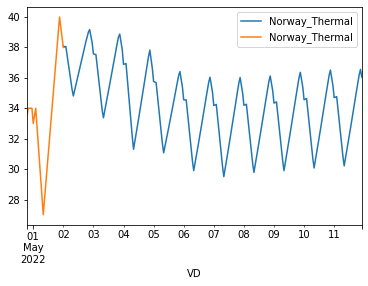

In [14]:
Norway_Thermal_forecast = arima_forecast(30, f1,104077964, 'Norway_Thermal', False, arima_calibration,False, time_end_forecast)

### Reading actual hydro content (NO1, NO2, NO3, NO4, NO5) curves

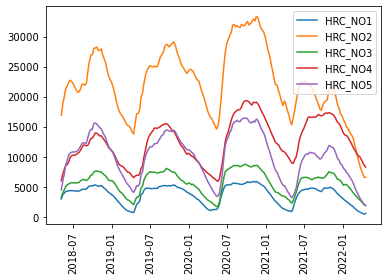

In [15]:
no1_content = pycomm.get_curves(102317846, date_first_monday, f1 , date_first_monday ,f1)
no1_content['Date'] = no1_content['VD']
no1_content = no1_content.set_index('Date')

plt.plot(no1_content.index,no1_content['V'], label = 'HRC_NO1')

no2_content = pycomm.get_curves(102317855, date_first_monday, f1 , date_first_monday ,f1)
no2_content['Date'] = no2_content['VD']
no2_content = no2_content.set_index('Date')

plt.plot(no2_content.index,no2_content['V'], label = 'HRC_NO2')

no3_content = pycomm.get_curves(102317857, date_first_monday, f1 , date_first_monday ,f1)
no3_content['Date'] = no3_content['VD']
no3_content = no3_content.set_index('Date')

plt.plot(no3_content.index,no3_content['V'], label = 'HRC_NO3')

no4_content = pycomm.get_curves(102317859, date_first_monday, f1 , date_first_monday ,f1)
no4_content['Date'] = no4_content['VD']
no4_content = no4_content.set_index('Date')

plt.plot(no4_content.index,no4_content['V'], label = 'HRC_NO4')


no5_content = pycomm.get_curves(103200289, date_first_monday, f1 , date_first_monday ,f1)
no5_content['Date'] = no5_content['VD']
no5_content = no5_content.set_index('Date')

plt.plot(no5_content.index,no5_content['V'], label = 'HRC_NO5')
plt.xticks(rotation=90)
plt.legend()
plt.show()

### Reading actual river flow temperature curves

In [16]:
bulken_TempActual = pycomm.get_curves(116980940, date_first_monday ,f1 , date_first_monday, f1)
bulken_InflowActual = pycomm.get_curves(106287083,date_first_monday ,f1 , date_first_monday, f1)

bulken_InflowActual = notAvailable(bulken_InflowActual,'bulken_InflowActual',time_series_df)
bulken_TempActual = notAvailable(bulken_TempActual,'bulken_TempActual',time_series_df)

austena_TempActual = pycomm.get_curves(116980909, date_first_monday ,f1 , date_first_monday, f1)
austena_InflowActual_highRes = pycomm.get_curves(106286853, date_first_monday ,f1 , date_first_monday, f1)

hourlyRes = time_series_df['VD']
austena_InflowActual = austena_InflowActual_highRes.loc[austena_InflowActual_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)

austena_TempActual = notAvailable(austena_TempActual,'austena_TempActual',time_series_df)
austena_InflowActual = notAvailable(austena_InflowActual,'austena_InflowActual',time_series_df)

gaulfoss_TempActual = pycomm.get_curves(116980988, date_first_monday ,f1 , date_first_monday, f1)
gaulfoss_InflowActual_highRes = pycomm.get_curves(106287485, date_first_monday ,f1 , date_first_monday, f1)

gaulfoss_InflowActual = gaulfoss_InflowActual_highRes.loc[gaulfoss_InflowActual_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)

gaulfoss_TempActual = notAvailable(gaulfoss_TempActual,'gaulfoss_TempActual',time_series_df)
gaulfoss_InflowActual = notAvailable(gaulfoss_InflowActual,'gaulfoss_InflowActual',time_series_df)

ovrevatin_TempActual = pycomm.get_curves(116980899, date_first_monday ,f1 , date_first_monday, f1)
ovrevatin_InflowActual = pycomm.get_curves(106287843, date_first_monday ,f1 , date_first_monday, f1)

ovrevatin_TempActual = notAvailable(ovrevatin_TempActual,'ovrevatin_TempActual',time_series_df)
ovrevatin_InflowActual = notAvailable(ovrevatin_InflowActual,'ovrevatin_InflowActual',time_series_df)

atnasjo_TempActual = pycomm.get_curves(116981002, date_first_monday ,f1 , date_first_monday, f1)
atnasjo_InflowActual = pycomm.get_curves(106286456, date_first_monday ,f1 , date_first_monday, f1)

atnasjo_TempActual = notAvailable(atnasjo_TempActual,'atnasjo_TempActual',time_series_df)
atnasjo_InflowActual = notAvailable(atnasjo_InflowActual,'atnasjo_InflowActual',time_series_df)

Consecutive NaN_bulken_InflowActual: 2
Consecutive NaN_bulken_TempActual: Zero
Consecutive NaN_austena_TempActual: Zero
Consecutive NaN_austena_InflowActual: 9
Consecutive NaN_gaulfoss_TempActual: Zero
Consecutive NaN_gaulfoss_InflowActual: 8
Consecutive NaN_ovrevatin_TempActual: Zero
Consecutive NaN_ovrevatin_InflowActual: 2
Consecutive NaN_atnasjo_TempActual: Zero
Consecutive NaN_atnasjo_InflowActual: 10


### Reading actual hydro production curves

Consecutive NaN_norway_hydroPro: 98


<AxesSubplot:xlabel='Date'>

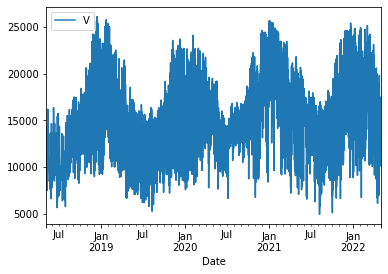

In [17]:
norway_hydroPro_highRes = pycomm.get_curves(103914626, date_first_monday ,f1 , date_first_monday, f1)
norway_hydroPro = norway_hydroPro_highRes.loc[norway_hydroPro_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
norway_hydroPro = notAvailable(norway_hydroPro,'norway_hydroPro',time_series_df)
norway_hydroPro.rename(columns={'VD':'Date'}, inplace = True)
norway_hydroPro = norway_hydroPro.set_index('Date')
norway_hydroPro['V'].plot(legend=True)

### Reading actual wind power production curves

Consecutive NaN_norway_wind: 98


<AxesSubplot:xlabel='Date'>

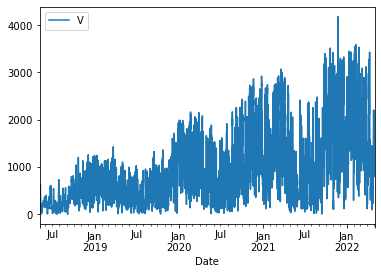

In [18]:
norway_wind_highRes = pycomm.get_curves(104077965, date_first_monday ,f1 , date_first_monday, f1)
norway_wind = norway_wind_highRes.loc[norway_wind_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
norway_wind = notAvailable(norway_wind,'norway_wind',time_series_df)
norway_wind.rename(columns={'VD':'Date'}, inplace = True)
norway_wind = norway_wind.set_index('Date')
norway_wind['V'].plot(legend=True)

### Reading actual thermal power production curves

Consecutive NaN_norway_thermal: 98


<AxesSubplot:xlabel='Date'>

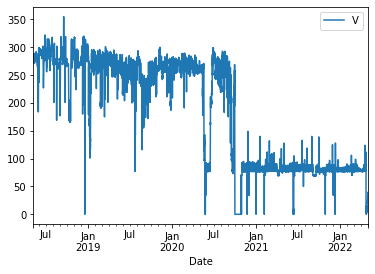

In [19]:
norway_thermal_highRes = pycomm.get_curves(104077964, date_first_monday ,f1 , date_first_monday, f1)
norway_thermal = norway_thermal_highRes.loc[norway_thermal_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
norway_thermal = notAvailable(norway_thermal,'norway_thermal',time_series_df)
norway_thermal.rename(columns={'VD':'Date'}, inplace = True)
norway_thermal = norway_thermal.set_index('Date')
norway_thermal['V'].plot(legend=True)

### Reading actual consumption curves

Consecutive NaN_norway_demand: 98


<AxesSubplot:xlabel='Date'>

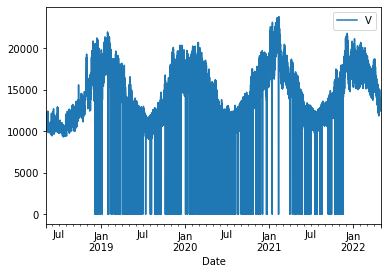

In [20]:
norway_dem_highRes = pycomm.get_curves(103914613, date_first_monday ,f1 , date_first_monday, f1)
norway_dem = norway_dem_highRes.loc[norway_dem_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
norway_dem = notAvailable(norway_dem,'norway_demand',time_series_df)
norway_dem.rename(columns={'VD':'Date'}, inplace = True)
norway_dem = norway_dem.set_index('Date')
norway_dem['V'].plot(legend=True)

### Reading actual NetImport (NO1, NO2, NO3, NO4, NO5) curves

In [21]:
# NO1

no1_netimport_highRes = pycomm.get_curves(107245527, date_first_monday ,f1 , date_first_monday, f1)
no1_netimport = no1_netimport_highRes.loc[no1_netimport_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
no1_netimport = notAvailable(no1_netimport,'no1_netimport',time_series_df)

# NO2

no2_netimport_highRes = pycomm.get_curves(107245524, date_first_monday ,f1 , date_first_monday, f1)
no2_netimport = no2_netimport_highRes.loc[no2_netimport_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
no2_netimport = notAvailable(no2_netimport,'no2_netimport',time_series_df)

# NO3

no3_netimport_highRes = pycomm.get_curves(107245529, date_first_monday ,f1 , date_first_monday, f1)
no3_netimport = no3_netimport_highRes.loc[no3_netimport_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
no3_netimport = notAvailable(no3_netimport,'no3_netimport',time_series_df)

# NO4

no4_netimport_highRes = pycomm.get_curves(107245525, date_first_monday ,f1 , date_first_monday, f1)
no4_netimport = no4_netimport_highRes.loc[no4_netimport_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
no4_netimport = notAvailable(no4_netimport,'no4_netimport',time_series_df)

# NO5

no5_netimport_highRes = pycomm.get_curves(107245531, date_first_monday ,f1 , date_first_monday, f1)
no5_netimport = no5_netimport_highRes.loc[no5_netimport_highRes['VD'].isin(hourlyRes)].reset_index(drop=True)
no5_netimport = notAvailable(no5_netimport,'no5_netimport',time_series_df)

# Whole Norway

nor_whole_netimport_actual = pd.DataFrame()
nor_whole_netimport_actual['Date'] = no1_netimport['VD']
nor_whole_netimport_actual['NetImport_Actual_Norway'] = no1_netimport['V'] + no2_netimport['V'] + no3_netimport['V'] + no4_netimport['V'] + no5_netimport['V'] 
nor_whole_netimport_actual = nor_whole_netimport_actual.set_index('Date')

Consecutive NaN_no1_netimport: Zero
Consecutive NaN_no2_netimport: 24
Consecutive NaN_no3_netimport: Zero
Consecutive NaN_no4_netimport: Zero
Consecutive NaN_no5_netimport: Zero


### Reading Effective precip forecast curve

<AxesSubplot:xlabel='Date'>

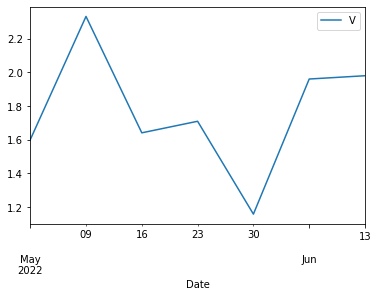

In [22]:
## The forecast is weekly so we don't need to use notAvailable function
Norway_EffPrecip_forecast = pycomm.get_curves(101613776, f1)
# Norway_EffPrecip_forecast = notAvailable(Norway_EffPrecip_forecast,'Norway_EffPrecip',time_series_df)
Norway_EffPrecip_forecast.rename(columns={'VD':'Date'}, inplace = True)
Norway_EffPrecip_forecast = Norway_EffPrecip_forecast.set_index('Date')
Norway_EffPrecip_forecast['V'].plot(legend=True)

### Reading actual Effective precip curve
We need weekly data, therefore it's necessary to change the time resolution and sum hourly data during each week. 

Consecutive NaN_Norway_EffPrecip: 167


<AxesSubplot:xlabel='Date'>

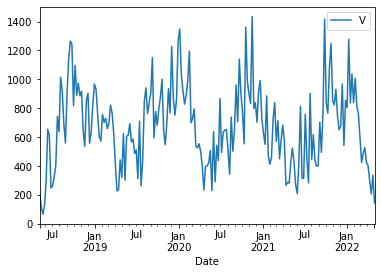

In [23]:
Norway_EffPrecip_history = pycomm.get_curves(101613776, date_first_monday ,f1 , date_first_monday, f1)
Norway_EffPrecip_history = notAvailable(Norway_EffPrecip_history,'Norway_EffPrecip',time_series_df)
Norway_EffPrecip_history.rename(columns={'VD':'Date'}, inplace = True)
Norway_EffPrecip_history = Norway_EffPrecip_history.set_index('Date')
weekly_Actual_EffPrecip = Norway_EffPrecip_history.resample('7D').sum()
weekly_Actual_EffPrecip['V'].plot(legend=True)

### A function to merge actual and forecast data points
We need to merge data points before training data, becasue there are some missing data points between actual and forecast values. The function will use interpolation method to fillback NaN values.<br>
Following function accepts three arguments:<br>
**time_fromNow_range**: Timestamps start from first Monday of actual data points until the last Monday in future that can be covered by forecast dates. <br> 
**forecast_column**: A part of the time windows that is defined above should be filled by forecast values.<br> 
**actual_column**: Actual values fill the rest of cells in the time windows.

In [24]:
def combine_actual_forecast(time_fromNow_range, forecast_column, actual_column):
    df_combine = pd.DataFrame()
    df_combine['Date'] = time_fromNow_range
    df_combine_forecast = pd.DataFrame()
    df_combine_forecast['Date'] = time_fromNow_range
    df_combine_actual = pd.DataFrame()
    df_combine_actual['Date'] = time_fromNow_range
    df_combine_actual = df_combine_actual.set_index('Date')
    df_combine_forecast = df_combine_forecast.set_index('Date')
    df_combine = df_combine.set_index('Date')
    df_combine_forecast = pd.merge(df_combine_forecast, forecast_column, on=['Date'],  how='left')
    df_combine_actual = pd.merge(df_combine_actual, actual_column, on=['Date'],  how='left')
    df_combine = pd.concat([df_combine_actual, df_combine_forecast],join="inner", axis=1, ignore_index= False)
    # https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.combine_first.html
    df_combine['combine']= df_combine.iloc[:,0].combine_first(df_combine.iloc[:,1])
    df = df_combine['combine'].to_frame()
    if df['combine'].first_valid_index() != 0:
        df['combine'].iloc[0] = df['combine'].loc[df['combine'].first_valid_index()]
        #inflow_Norway.iloc[0, inflow_Norway.columns.get_loc('V')] = numb
        #inflow_Norway.iloc[0, inflow_Norway.columns.get_loc('V')] = inflow_Norway['V'].loc[inflow_Norway['V'].first_valid_index()]
        #inflow_Norway['V'].loc[0]= inflow_Norway['V'].loc[inflow_Norway.first_valid_index()]
        curve = df.interpolate(method ='linear', limit_direction ='forward')
    else:
        curve = df.interpolate(method ='linear', limit_direction ='forward')
    return curve

### Calculating hydro production forecast
Hydro production + thermal production + wind power + exchange = Consumption <br>


In [25]:
# We need a time window and fit all data into it
time_series_range = pd.date_range(date_first_monday,time_end_forecast , freq='H')


norway_comodities_forecast = pd.DataFrame()
norway_comodities_forecast['Date'] = time_series_range 


combine_netImport_no = combine_actual_forecast(time_series_range, no_whole_NetImport_forecast['NetImport_forecast_Norway'], nor_whole_netimport_actual['NetImport_Actual_Norway'])
norway_comodities_forecast['NetImport'] = combine_netImport_no['combine'].values

## Index of two df should be the same type if you want to use the combine_actual_forecast function
combine_wind_no = combine_actual_forecast(time_series_range, no_whole_wind_forecast['Wind_forecast_Norway'], norway_wind['V'])
norway_comodities_forecast['Wind'] = combine_wind_no['combine'].values

combine_demand_no = combine_actual_forecast(time_series_range, no_whole_dem_forecast['Demand_forecast_Norway'], norway_dem['V'])
norway_comodities_forecast['Demand'] = combine_demand_no['combine'].values

Norway_Thermal_forecast = pd.DataFrame(Norway_Thermal_forecast)
Norway_Thermal_forecast['Date'] = Norway_Thermal_forecast.index
Norway_Thermal_forecast=Norway_Thermal_forecast.set_index('Date')

combine_thermal_no = combine_actual_forecast(time_series_range, Norway_Thermal_forecast['Norway_Thermal'], norway_thermal['V'])
norway_comodities_forecast['Thermal'] = combine_thermal_no['combine'].values

norway_comodities_forecast['HydroProduction'] = norway_comodities_forecast['Demand'] - norway_comodities_forecast['Thermal'] - norway_comodities_forecast['Wind'] - norway_comodities_forecast['NetImport']

norway_comodities_forecast = norway_comodities_forecast.set_index('Date')

### Merging Precipitation forecast and actual data points

In [26]:
combine_precip_no = combine_actual_forecast(time_series_range, Norway_EffPrecip_forecast ['V'], weekly_Actual_EffPrecip['V'])
norway_comodities_forecast['EffPrecip'] = combine_precip_no['combine'].values

### Cleaning data and including timestamps

In [27]:
def Norway_history_inflow(river_variable):
    river_variable.rename(columns={'VD':'Date'}, inplace = True)
    river_variable = river_variable.set_index('Date')
    # if 'Inflow' in river_name: 
    #     river_variable = river_variable.resample('7D').sum()
    # else:
    #     river_variable = river_variable.resample('7D').mean()

    # Norway_history_hydroreservior[river_name] = river_variable['V']
    
    return river_variable

bulken_InflowActual = Norway_history_inflow(bulken_InflowActual)
bulken_TempActual = Norway_history_inflow(bulken_TempActual)
austena_TempActual = Norway_history_inflow(austena_TempActual)
austena_InflowActual = Norway_history_inflow(austena_InflowActual)
gaulfoss_TempActual = Norway_history_inflow(gaulfoss_TempActual)
gaulfoss_InflowActual = Norway_history_inflow(gaulfoss_InflowActual)
ovrevatin_TempActual = Norway_history_inflow(ovrevatin_TempActual)
ovrevatin_InflowActual = Norway_history_inflow(ovrevatin_InflowActual)
atnasjo_TempActual = Norway_history_inflow(atnasjo_TempActual)
atnasjo_InflowActual = Norway_history_inflow(atnasjo_InflowActual)

bulken_InflowForecast = Norway_history_inflow(bulken_InflowForecast)
bulken_TempForecast = Norway_history_inflow(bulken_TempForecast)
austena_TempForecast = Norway_history_inflow(austena_TempForecast)
austena_InflowForecast = Norway_history_inflow(austena_InflowForecast)
gaulfoss_TempForecast = Norway_history_inflow(gaulfoss_TempForecast)
gaulfoss_InflowForecast = Norway_history_inflow(gaulfoss_InflowForecast)
ovrevatin_TempForecast = Norway_history_inflow(ovrevatin_TempForecast)
ovrevatin_InflowForecast = Norway_history_inflow(ovrevatin_InflowForecast)
atnasjo_TempForecast = Norway_history_inflow(atnasjo_TempForecast)
atnasjo_InflowForecast = Norway_history_inflow(atnasjo_InflowForecast)

### Merging Flow/Temp forecast and actual data points

In [28]:
combine_bulken_InflowActual = combine_actual_forecast(time_series_range, bulken_InflowForecast ['V'], bulken_InflowActual['V'])
norway_comodities_forecast['bulken_Inflow'] = combine_bulken_InflowActual['combine'].values


# combine_bulken_InflowActual.to_csv('combine_bulken_InflowActual.csv')
# norway_comodities_forecast.to_csv('norway_comodities_forecast.csv')
combine_bulken_TempActual = combine_actual_forecast(time_series_range, bulken_TempForecast ['V'], bulken_TempActual['V'])
norway_comodities_forecast['bulken_Temp'] = combine_bulken_TempActual['combine'].values

combine_austena_TempActual = combine_actual_forecast(time_series_range, austena_TempForecast ['V'], austena_TempActual['V'])
norway_comodities_forecast['austena_Temp'] = combine_austena_TempActual['combine'].values

combine_austena_InflowActual = combine_actual_forecast(time_series_range, austena_InflowForecast ['V'], austena_InflowActual['V'])
norway_comodities_forecast['austena_Inflow'] = combine_austena_InflowActual['combine'].values

combine_gaulfoss_TempActual = combine_actual_forecast(time_series_range, gaulfoss_TempForecast ['V'], gaulfoss_TempActual['V'])
norway_comodities_forecast['gaulfoss_Temp'] = combine_gaulfoss_TempActual['combine'].values

combine_gaulfoss_InflowActual = combine_actual_forecast(time_series_range, gaulfoss_InflowForecast ['V'], gaulfoss_InflowActual['V'])
norway_comodities_forecast['gaulfoss_Inflow'] = combine_gaulfoss_InflowActual['combine'].values

combine_ovrevatin_TempActual = combine_actual_forecast(time_series_range, ovrevatin_TempForecast ['V'], ovrevatin_TempActual['V'])
norway_comodities_forecast['ovrevatin_Temp'] = combine_ovrevatin_TempActual['combine'].values

combine_ovrevatin_InflowActual = combine_actual_forecast(time_series_range, ovrevatin_InflowForecast ['V'], ovrevatin_InflowActual['V'])
norway_comodities_forecast['ovrevatin_Inflow'] = combine_ovrevatin_InflowActual['combine'].values

combine_atnasjo_TempActual = combine_actual_forecast(time_series_range, atnasjo_TempForecast ['V'], atnasjo_TempActual['V'])
norway_comodities_forecast['atnasjo_Temp'] = combine_atnasjo_TempActual['combine'].values

combine_atnasjo_InflowActual = combine_actual_forecast(time_series_range, atnasjo_InflowForecast ['V'], atnasjo_InflowActual['V'])
norway_comodities_forecast['atnasjo_Inflow'] = combine_atnasjo_InflowActual['combine'].values

## We need to drop some columns include ['NetImport', 'Wind', 'Demand', 'Thermal'] 
## because we have used them to build hydroProduction
norway_comodities_forecast = norway_comodities_forecast.drop(labels=['NetImport', 'Wind', 'Demand', 'Thermal'], axis=1)


### Changing time resolution to weekly data points
Regarding weekly data, we use mean aggregate function for temperature and sum aggregate function for inflow. 

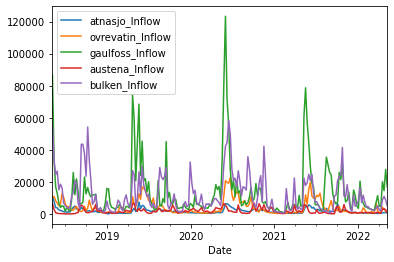

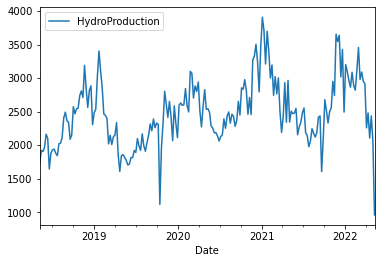

In [37]:
weekly_Norway_params = pd.DataFrame()

weekly_Norway_params['atnasjo_Inflow'] = norway_comodities_forecast['atnasjo_Inflow'].resample('7D').sum() 
weekly_Norway_params['ovrevatin_Inflow'] = norway_comodities_forecast['ovrevatin_Inflow'].resample('7D').sum() 
weekly_Norway_params['gaulfoss_Inflow'] = norway_comodities_forecast['gaulfoss_Inflow'].resample('7D').sum() 
weekly_Norway_params['austena_Inflow'] = norway_comodities_forecast['austena_Inflow'].resample('7D').sum()
weekly_Norway_params['bulken_Inflow'] = norway_comodities_forecast['bulken_Inflow'].resample('7D').sum() 
#weekly_Norway_params['atnasjo_Temp'] = norway_comodities_forecast['atnasjo_Temp'].resample('7D').mean()
weekly_Norway_params['ovrevatin_Temp'] = norway_comodities_forecast['ovrevatin_Temp'].resample('7D').mean()
#weekly_Norway_params['gaulfoss_Temp'] = norway_comodities_forecast['gaulfoss_Temp'].resample('7D').mean()
#weekly_Norway_params['austena_Temp'] = norway_comodities_forecast['austena_Temp'].resample('7D').mean()
#weekly_Norway_params['bulken_Temp'] = norway_comodities_forecast['bulken_Temp'].resample('7D').mean()
#weekly_Norway_params['EffPrecip'] = norway_comodities_forecast['EffPrecip'].resample('7D').sum()
weekly_Norway_params['HydroProduction'] = (norway_comodities_forecast['HydroProduction'].resample('7D').sum())/1000

weekly_Norway_params[['atnasjo_Inflow','ovrevatin_Inflow','gaulfoss_Inflow',
                     'austena_Inflow','bulken_Inflow']].plot(legend=True)
plt.show()

#weekly_Norway_params[['EffPrecip']].plot(legend=True)
#plt.show()

weekly_Norway_params[['HydroProduction']].plot(legend=True)
plt.show()


### Lagged Explanatory Variables such as river flow, temperature, and precipitation
We need to include lagged variables to capture all effects with delay.

In [38]:
weekly_Norway_params['atnasjo_Inflow_lag'] = norway_comodities_forecast['atnasjo_Inflow'].resample('7D').sum().shift(periods=1) 
weekly_Norway_params['ovrevatin_Inflow_lag'] = norway_comodities_forecast['ovrevatin_Inflow'].resample('7D').sum().shift(periods=1) 
weekly_Norway_params['gaulfoss_Inflow_lag'] = norway_comodities_forecast['gaulfoss_Inflow'].resample('7D').sum().shift(periods=1) 
weekly_Norway_params['austena_Inflow_lag'] = norway_comodities_forecast['austena_Inflow'].resample('7D').sum().shift(periods=1)
weekly_Norway_params['bulken_Inflow_lag'] = norway_comodities_forecast['bulken_Inflow'].resample('7D').sum().shift(periods=1) 
weekly_Norway_params['atnasjo_Temp_lag'] = norway_comodities_forecast['atnasjo_Temp'].resample('7D').mean().shift(periods=1)
#weekly_Norway_params['ovrevatin_Temp_lag'] = norway_comodities_forecast['ovrevatin_Temp'].resample('7D').mean().shift(periods=1)
#weekly_Norway_params['gaulfoss_Temp_lag'] = norway_comodities_forecast['gaulfoss_Temp'].resample('7D').mean().shift(periods=1)
#weekly_Norway_params['austena_Temp_lag'] = norway_comodities_forecast['austena_Temp'].resample('7D').mean().shift(periods=1)
#weekly_Norway_params['bulken_Temp_lag'] = norway_comodities_forecast['bulken_Temp'].resample('7D').mean().shift(periods=1)
weekly_Norway_params['EffPrecip_lag'] = norway_comodities_forecast['EffPrecip'].resample('7D').sum().shift(periods=1)

weekly_Norway_params.drop(weekly_Norway_params.head(1).index,inplace=True)

weekly_Norway_params['atnasjo_Inflow_ll'] = norway_comodities_forecast['atnasjo_Inflow'].resample('7D').sum().shift(periods=2) 
weekly_Norway_params['ovrevatin_Inflow_ll'] = norway_comodities_forecast['ovrevatin_Inflow'].resample('7D').sum().shift(periods=2) 
weekly_Norway_params['gaulfoss_Inflow_ll'] = norway_comodities_forecast['gaulfoss_Inflow'].resample('7D').sum().shift(periods=2) 
weekly_Norway_params['austena_Inflow_ll'] = norway_comodities_forecast['austena_Inflow'].resample('7D').sum().shift(periods=2)
weekly_Norway_params['bulken_Inflow_ll'] = norway_comodities_forecast['bulken_Inflow'].resample('7D').sum().shift(periods=2) 
# weekly_Norway_params['atnasjo_Temp_ll'] = norway_comodities_forecast['atnasjo_Temp'].resample('7D').mean().shift(periods=2)
# weekly_Norway_params['ovrevatin_Temp_ll'] = norway_comodities_forecast['ovrevatin_Temp'].resample('7D').mean().shift(periods=2)
# weekly_Norway_params['gaulfoss_Temp_ll'] = norway_comodities_forecast['gaulfoss_Temp'].resample('7D').mean().shift(periods=2)
# weekly_Norway_params['austena_Temp_ll'] = norway_comodities_forecast['austena_Temp'].resample('7D').mean().shift(periods=2)
# weekly_Norway_params['bulken_Temp_ll'] = norway_comodities_forecast['bulken_Temp'].resample('7D').mean().shift(periods=2)
# weekly_Norway_params['EffPrecip_ll'] = norway_comodities_forecast['EffPrecip'].resample('7D').sum().shift(periods=2)

weekly_Norway_params.drop(weekly_Norway_params.head(1).index,inplace=True)
### We need to drop last row if it's not included whole week
week_day = time_end_forecast.day_name()
if 'Sun' not in week_day:
    weekly_Norway_params.drop(weekly_Norway_params.tail(1).index,inplace=True)
else:
    pass

### Calculating difference between weekly hydro reservoir content 
Weekly inflow, precipitation, temperature, and ect. affect the difference between weekly hydro reservoir content. We need forecast this difference and then rebuild the total hydro reservoir content.

In [39]:
weekly_Norway_params['Content'] = (no1_content['V'] + no2_content['V'] + no3_content['V'] + no4_content['V'] + no5_content['V']).diff()#.shift(periods=-1)
weekly_Norway_params['netContent'] = weekly_Norway_params['Content'] + weekly_Norway_params['HydroProduction']

weekly_Norway_hydCon = pd.DataFrame()
weekly_Norway_hydCon['Date'] = weekly_Norway_params.index
weekly_Norway_hydCon = weekly_Norway_hydCon.set_index('Date')
weekly_Norway_hydCon = weekly_Norway_params[['HydroProduction']]
weekly_Norway_hydCon['Cont'] = (no1_content['V'] + no2_content['V'] + no3_content['V'] + no4_content['V'] + no5_content['V'])#.shift(periods=-1)
weekly_Norway_hydCon['lag_Cont'] = weekly_Norway_hydCon['Cont'].copy().shift(periods=1)
weekly_Norway_params= weekly_Norway_params.drop(labels=['Content', 'HydroProduction'], axis=1)

test_weekly_Norway = weekly_Norway_params[weekly_Norway_params['netContent'].isnull() == True].drop(labels=['netContent'], axis=1)

train_weekly_Norway = weekly_Norway_params[weekly_Norway_params['netContent'].isnull() == False]


### Random Forest Regression
We need two groups of data set include test and train. The algorithm will be trained by using train data set and then we need to use the model to predict test dataset.  

Training Features Shape: (201, 18)
Training Labels Shape: (201,)
Testing Features Shape: (4, 18)
Testing Labels Shape: (4,)
Mean Absolute Error (Norway): 271.74 degrees.
Accuracy_Norway: 84.63 %.


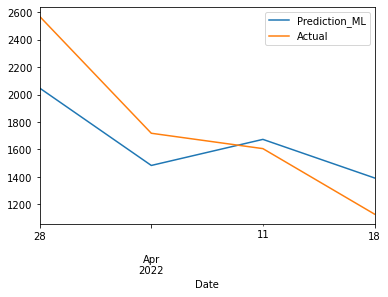

In [41]:
ml_Norway_hydroreservior = train_weekly_Norway.copy()
# Use numpy to convert to arrays
labels_Norway = np.array(ml_Norway_hydroreservior['netContent'])
# Remove the labels from the features
# axis 1 refers to the columns
ml_Norway_hydroreservior= ml_Norway_hydroreservior.drop('netContent', axis = 1)# Saving feature names for later use
feature_list_Norway = list(ml_Norway_hydroreservior.columns)# Convert to numpy array
features_Norway = np.array(ml_Norway_hydroreservior)

## Training and Testing Sets
# Using Skicit-learn to split data into training and testing sets

# Split the data into training and testing sets
train_features_Norway, test_features_Norway, train_labels_Norway, test_labels_Norway = train_test_split(features_Norway,
                                                                                                        labels_Norway, 
                                                                                                        test_size = 0.015, 
                                                                                                        random_state = 42)
print('Training Features Shape:', train_features_Norway.shape)
print('Training Labels Shape:', train_labels_Norway.shape)
print('Testing Features Shape:', test_features_Norway.shape)
print('Testing Labels Shape:', test_labels_Norway.shape)

## Establish Baseline, a sensible measure that we hope to beat with our model
## If our model cannot improve upon the baseline, then it will be a failure and 
## we should try a different model or admit that machine learning is not right for our problem.
# The baseline predictions are the historical averages
### train Model
# Import the model we are using

# Instantiate model with 1000 decision trees
rf_Norway = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf_Norway.fit(train_features_Norway, train_labels_Norway)


# Use the forest's predict method on the test data
predictions_Norway = rf_Norway.predict(test_features_Norway)
# Calculate the absolute errors
errors_Norway = abs(predictions_Norway - test_labels_Norway)
# Print out the mean absolute error (mae)
print('Mean Absolute Error (Norway):', round(np.mean(errors_Norway), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape_Norway = 100 * (errors_Norway / test_labels_Norway)# Calculate and display accuracy
accuracy_Norway = 100 - np.mean(mape_Norway)
print('Accuracy_Norway:', round(accuracy_Norway, 2), '%.')

length_test_Norway = len(test_labels_Norway) 
indeces_Norway = train_weekly_Norway.index.to_series()[-1*(length_test_Norway):]
Prediction_Norway_plot = pd.DataFrame()
Prediction_Norway_plot['Date'] = indeces_Norway
Prediction_Norway_plot['Prediction_ML'] = predictions_Norway
Prediction_Norway_plot['Actual'] =  test_labels_Norway
Prediction_Norway_plot = Prediction_Norway_plot.set_index('Date')
Prediction_Norway_plot.plot(legend = True)
plt.show()

### Heatmap
A correlation heatmap is a heatmap that shows a 2D correlation matrix between two discrete dimensions, using colored cells to represent data from usually a monochromatic scale. I used heatmap to calibrate the model.

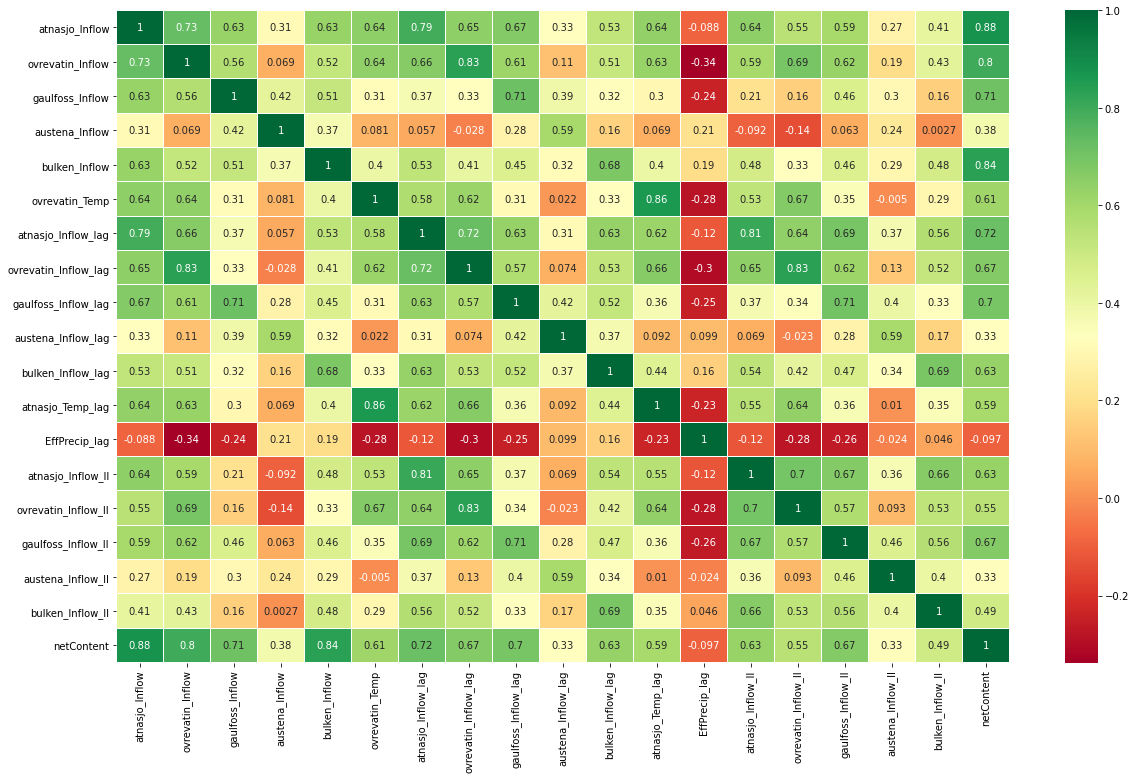

In [42]:
import seaborn as sns
sns.heatmap(weekly_Norway_params.corr(),annot=True,cmap='RdYlGn',linewidths=0.2) 
fig=plt.gcf()
fig.set_size_inches(20,12)
plt.show()

### Forecast
In order to forecast Norwegian HRC, I used the fitted RF model which already is trained. The accuracy of model is around 85%. 

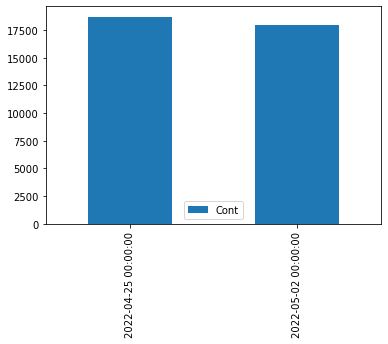

2022-04-25    18718.298057
2022-05-02    17980.604249
Name: Cont, dtype: float64


In [45]:
predictions_Norway_real = rf_Norway.predict(test_weekly_Norway)

Prediction_Norway_plot = pd.DataFrame()

weekly_Norway_hydCon = weekly_Norway_hydCon[weekly_Norway_hydCon['Cont'].isnull() == True]

Prediction_Norway_plot['Date'] = test_weekly_Norway.index
Prediction_Norway_plot['Prediction_ML'] = predictions_Norway_real
Prediction_Norway_plot = Prediction_Norway_plot.set_index('Date')

weekly_Norway_hydCon['predict'] = Prediction_Norway_plot['Prediction_ML'] 

predict_nor = {}
x = 0

for index, row in weekly_Norway_hydCon.iterrows():
    row_new = row.to_frame().T
    
    if not row_new['lag_Cont'].isnull().values.any():
        row_new['Cont'] = row_new['predict'] - row_new['HydroProduction'] + row_new['lag_Cont']
        predict_nor[index] = row_new
        x = row_new['Cont'].to_numpy()[0]
    else:
        row_new['Cont'] = row_new['predict'] - row_new['HydroProduction'] + x
        predict_nor[index] = row_new
        x = row_new['Cont'].to_numpy()[0]

### https://stackoverflow.com/questions/30233982/merge-dataframes-in-a-dictionary
df_predict = pd.concat(predict_nor.values())

df_predict['Cont'].plot.bar(legend=True)
plt.show()

print(df_predict['Cont'])